In [1]:
import ROOT
import ostap.fixes.fixes
from ostap.core.core import cpp, Ostap
from ostap.core.core import pwd, cwd, ROOTCWD
from ostap.core.core import rootID, funcID, funID, fID, histoID, hID, dsID
from ostap.core.core import VE
from ostap.histos.histos import h1_axis, h2_axes, h3_axes
from ostap.histos.graphs import makeGraph, hToGraph, hToGraph2, hToGraph3, lw_graph
import ostap.trees.trees
import ostap.trees.cuts
import ostap.histos.param
import ostap.histos.compare
import ostap.io.root_file
import ostap.math.models
import ostap.fitting.roofit 
import ostap.fitting.models as Models

Welcome to JupyROOT 6.20/06


In [2]:
canv = ROOT.TCanvas("canv","canv",900,450)
rfile = ROOT.TFile("new.root","READ")
ds = rfile["tree"]

In [165]:
from math import atan, sqrt
W1   = 0.004 # mm/ns
zCSC = 853.1 # mm
T23 = 4.97526
my_events = []
for ev in ds:
    lCSC  = sqrt( ev.xCSC**2 + ev.yCSC**2 )
    zTPC  = ev.peak1*W1
    Treco = ev.T/35310.
    if Treco >T23-0.05 and Treco<T23+0.05:
        evt = {"T":Treco, "l":lCSC, "z":zTPC, "Atr":ev.THETAe, "Ttr":ev.Tp}
        my_events.append( evt )
print("EVENTS SELECTED: " + str(len(my_events)))

EVENTS SELECTED: 2981


In [166]:
def find_pair( event, event_list, base=180. ):
    num = 0
    min_dist = 1000.
    for i in range(len(event_list)):
        if abs(abs(event_list[i]["z"]-event["z"])-base)<min_dist:
            min_dist  = abs(abs(event_list[i]["z"]-event["z"])-base)
            num = i
    return num

In [167]:
pair_list = []
rng = range(900)
for idx in rng:
    evt = my_events.pop(idx)
    pair_list.append( [evt , my_events.pop( find_pair( evt, my_events ) ) ] )

Warning in <TROOT::Append>: Replacing existing TH1: h_dZ (Potential memory leak).


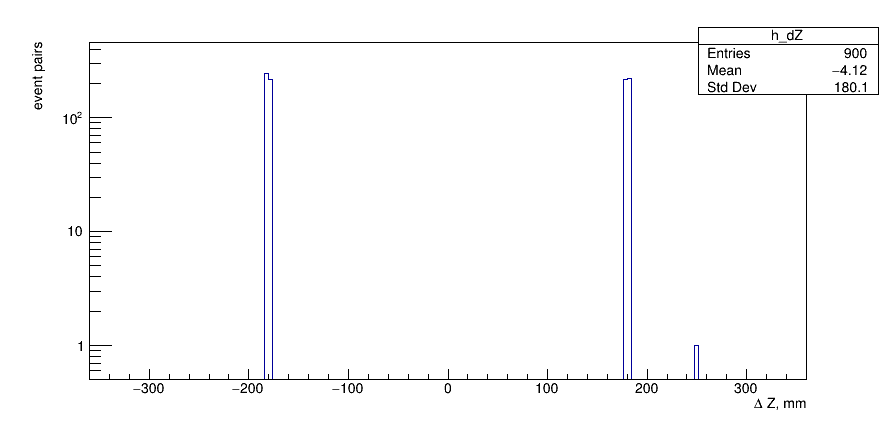

In [168]:
h_dZ = ROOT.TH1F("h_dZ",";#Delta Z, mm; event pairs", 180, -360,360 )
for pair in pair_list:
#    h_dZ.Fill( abs(pair[0]["z"] - pair[1]["z"]) )
    h_dZ.Fill( pair[1]["z"] - pair[0]["z"] )
h_dZ.Draw()
canv.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: h_A (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_R (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_T (Potential memory leak).


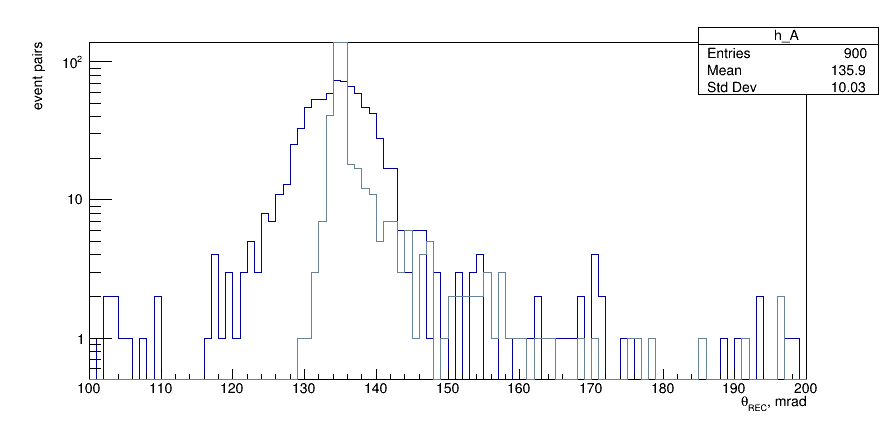

In [169]:
h_A = ROOT.TH1F("h_A",";#theta_{REC}, mrad; event pairs", 100, 100, 200)
h_R = ROOT.TH1F("h_R",";#theta_{REC}, mrad; event pairs", 100, 100, 200)
h_T = ROOT.TH1F("h_T",";#theta_{REC}, mrad; event pairs", 100, 100, 200)
h_T.SetLineColor(36)
theta_rec_list = []
for pair in pair_list:
    min_idx = 0
    max_idx = 1
    if pair[1]["z"] - pair[0]["z"] < 0:
        min_idx = 1
        max_idx = 0
    dZ = pair[max_idx]["z"] - pair[min_idx]["z"]
    dL = pair[min_idx]["l"] - pair[max_idx]["l"]
    theta_rec = 1000.*atan( dL / dZ )
    theta_rec_list.append( theta_rec )
    #print(theta_rec)
    h_A.Fill( theta_rec )
    h_T.Fill( 1000.*0.5*(pair[min_idx]["Atr"] + pair[max_idx]["Atr"]))
ROOT.gPad.SetLogy()
h_A.Draw()
h_T.Draw("same")
canv.Draw()

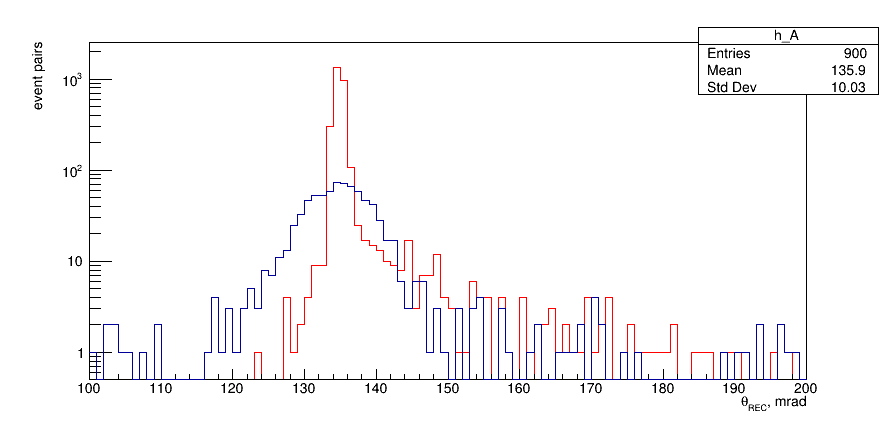

In [170]:
theta_true_list = []
T_true_list = []
T_rec_list = []
for ev in ds:
    Treco = ev.T/35310
    if Treco >T23-0.05 and Treco<T23+0.05:
        theta_true_list.append( 1000.*ev.THETAe )
        h_R.Fill( 1000.*ev.THETAe )
        T_true_list.append( ev.Tp )
        T_rec_list.append ( ev.T/35310. )

h_R.SetLineColor(2)
h_R.Draw()
h_A.Draw("same")
canv.Draw()

In [171]:
import statistics
median_theta_rec  = statistics.median( theta_rec_list  )
median_theta_true = statistics.median( theta_true_list )
mean_theta_rec  = statistics.mean( theta_rec_list  )
mean_theta_true = statistics.mean( theta_true_list )
mode_theta_rec  = statistics.mode( theta_rec_list  )
mode_theta_true = statistics.mode( theta_true_list )
print("Median angle (rec.): " + str( median_theta_rec  ) )
print("Median angle (true): " + str( median_theta_true ) )
print(median_theta_rec  - median_theta_true)
print("Mean angle   (rec.): " + str( mean_theta_rec    ) )
print("Mean angle   (true): " + str( mean_theta_true   ) )
print(mean_theta_rec  - mean_theta_true)
print("Mode angle   (rec.): " + str( mode_theta_rec    ) )
print("Mode angle   (true): " + str( mode_theta_true   ) )
print(mode_theta_rec  - mode_theta_true)
print("\n")
median_T_rec  = statistics.median( T_rec_list  )
median_T_true = statistics.median( T_true_list )
mean_T_rec  = statistics.mean( T_rec_list  )
mean_T_true = statistics.mean( T_true_list )
print("Median T (rec.): " + str( median_T_rec  ) )
print("Median T (true): " + str( median_T_true ) )
print(median_T_rec  - median_T_true)
print("Mean T   (rec.): " + str( mean_T_rec    ) )
print("Mean T   (true): " + str( mean_T_true   ) )
print(mean_T_rec  - mean_T_true)

Median angle (rec.): 134.94243568500445
Median angle (true): 134.88200306892395
0.06043261608050443
Mean angle   (rec.): 134.82251588713862
Mean angle   (true): 137.2392553584922
-2.4167394713535657
Mode angle   (rec.): 129.04517372880053
Mode angle   (true): 134.44699347019196
-5.401819741391421


Median T (rec.): 4.972148028178986
Median T (true): 4.975840091705322
-0.00369206352633622
Mean T   (rec.): 4.972993220313662
Mean T   (true): 4.975683334968667
-0.002690114655004905


In [53]:
statistics.mode(theta_rec_list )

132.23275247709924

In [54]:
statistics.mode(theta_true_list )

134.44699347019196